In [28]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

%matplotlib inline

In [5]:
def get_data(coin = 'bitcoin', year = 2017):
    
    df = pd.read_csv(f'./data/{coin}_{year}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')
    df.set_index('timestamp', inplace = True)
    df.sort_index(inplace = True)
    df = df[['Count','Open','High','Low','Close','Volume','VWAP','Target']]
    
    return df

In [6]:
btc2017 = get_data()
btc2018 = get_data('bitcoin', 2018)
btc2019 = get_data('bitcoin', 2019)
btc2020 = get_data('bitcoin', 2020)
btc2021 = get_data('bitcoin', 2021)

In [7]:
btc = pd.concat([btc2017, btc2018, btc2019, btc2020, btc2021], axis = 0)

In [8]:
def resample(df, time_period = '1D'):
    df = df.resample(time_period).first()
    return df

In [9]:
def add_cols(df, momentum = 7, volatility = 30, sma = 50):
    
    df['diff'] = df['Close'] - df['Close'].shift(1)
    df['log_close'] = np.log(df['Close'])
    df['log_diff'] = df['log_close'] - df['log_close'].shift(1)
    df['log_return'] = df['log_close']/(df['log_close'].shift(1))
    df['direction'] = np.where(df['log_return'] > 0, 1, 0)
    df['momentum'] = df['log_return'].rolling(momentum).mean().shift(1)
    df['volatility'] = df['log_return'].rolling(volatility).std().shift(1)
    df['sma_7'] = df['Close'].rolling(7).mean()
    df['sma_50'] = df['Close'].rolling(50).mean()
    df['sma_200'] = df['Close'].rolling(200).mean()
    sma_distance = f'sma_{sma}'
    df[sma_distance] = (df['Close'] - df['Close'].rolling(sma).mean()).shift(1)
    df['log_sqrt_close'] = np.sqrt(df['log_close'])
    
    df = df[df['Close'].notna()]
    
    return df

In [10]:
daily = resample(btc)
weekly = resample(btc, '1W')
monthly = resample(btc, '1M')

In [11]:
daily = add_cols(daily)
weekly = add_cols(weekly, momentum = 1, volatility = 4, sma = 7)

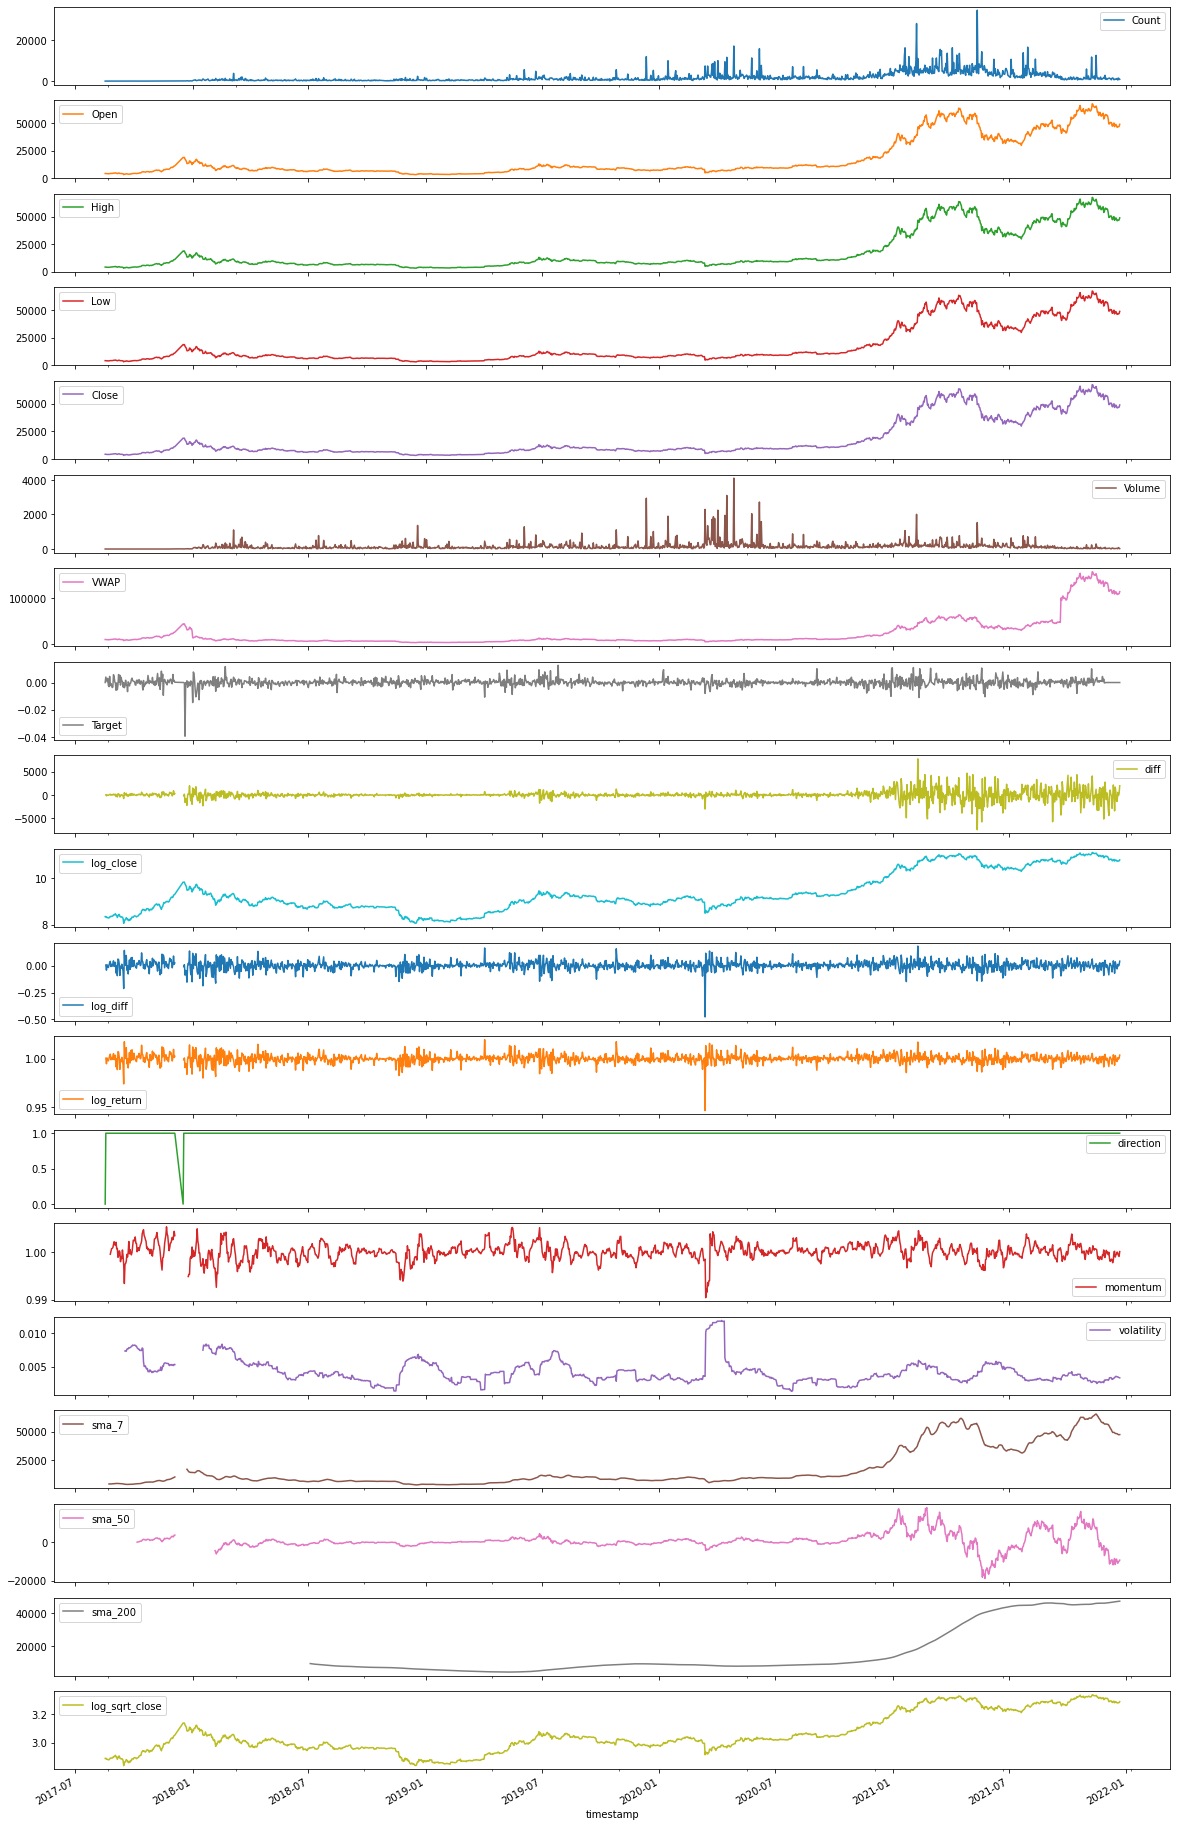

In [12]:
daily.plot(figsize=(20,36), subplots=True, legend=True);

In [24]:
x = daily['log_return'].dropna()

In [25]:
adf = adfuller(x)
adf

(-27.361421584716965,
 0.0,
 1,
 1573,
 {'1%': -3.4345140199818918,
  '5%': -2.8633791658322503,
  '10%': -2.567749139071643},
 -12324.365964175971)

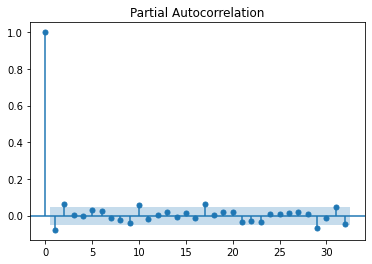

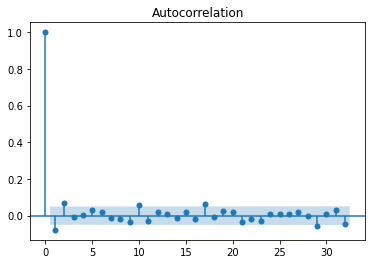

In [32]:
plot_pacf(x);
plot_acf(x);

In [20]:
mod_arma = ARMA(x, order=(1,0))
res_arma = mod_arma.fit()
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:             log_return   No. Observations:                 1575
Model:                     ARMA(1, 0)   Log Likelihood                6260.766
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 04 Jan 2022   AIC                         -12515.532
Time:                        10:08:16   BIC                         -12499.446
Sample:                             0   HQIC                        -12509.554
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0001      0.000   9415.552      0.000       1.000       1.000
ar.L1.log_return    -0.0779      0.025     -3.100      0.002      -0.127      -0.029
                            

In [22]:
mod2_arma = ARMA(x, order=(0,1))
res2_arma = mod2_arma.fit()
print(res2_arma.summary())

                              ARMA Model Results                              
Dep. Variable:             log_return   No. Observations:                 1575
Model:                     ARMA(0, 1)   Log Likelihood                6260.224
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 04 Jan 2022   AIC                         -12514.447
Time:                        10:08:33   BIC                         -12498.361
Sample:                             0   HQIC                        -12508.469
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0001      0.000   9381.057      0.000       1.000       1.000
ma.L1.log_return    -0.0692      0.024     -2.926      0.003      -0.115      -0.023
                            

In [36]:
best_model = SARIMAX(x, order=(0, 1, 2),
                     seasonal_order=(1, 1, 2, 5)).fit(disp=-1)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        log_return   No. Observations:                 1575
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 5)   Log Likelihood                6212.893
Date:                           Tue, 04 Jan 2022   AIC                         -12413.786
Time:                                   10:15:55   BIC                         -12381.637
Sample:                                        0   HQIC                        -12401.836
                                          - 1575                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0685      0.020    -53.269      0.000      -1.108      -1.029
ma.L2          0.0742      0.020      3.684      0.000       0.035       0.114
ar.S.L5       -0.9263      0.139     -6.656      0.000      -1.199      -0.654
ma.S.L5       -0.0637      0.136     -0.467      0.641      -0.331       0.204
ma.S.L10      -0.9344      0.135     -6.904      0.000      -1.200      -0.669
sigma2      2.075e-05   7.22e-07     28.731      0.000    1.93e-05    2.22e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             12122.31
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
model = ARIMA(x, order=(1,1,1))
model2 = model.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.log_return   No. Observations:                 1574
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6249.272
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 04 Jan 2022   AIC                         -12490.544
Time:                        10:20:34   BIC                         -12469.099
Sample:                             1   HQIC                        -12482.574
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -2.77e-07   1.79e-06     -0.155      0.877   -3.79e-06    3.23e-06
ar.L1.D.log_return    -0.0496      0.026     -1.896      0.058      -0.101       0.002
ma.L1.D.log_return    -0.9844      0.011    -89.976      0.000      -1.006      -0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -20.1547           +0.0000j           20.1547            0.5000
MA.1            1.0159           +0.0000j            1.0159            0.0000
-----------------------------------------------------------------------------
"""

In [40]:
model = ARIMA(x, order =(1,0,1))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             log_return   No. Observations:                 1575
Model:                     ARMA(1, 1)   Log Likelihood                6262.833
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 04 Jan 2022   AIC                         -12517.666
Time:                        10:37:47   BIC                         -12496.218
Sample:                             0   HQIC                        -12509.695
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0001      0.000   9235.566      0.000       1.000       1.000
ar.L1.log_return    -0.5151      0.176     -2.928      0.003      -0.860      -0.170
ma.L1.log_return     0.4349      0.184      2.359      0.018       0.074       0.796
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9415           +0.0000j            1.9415            0.5000
MA.1           -2.2992           +0.0000j            2.2992            0.5000
-----------------------------------------------------------------------------
"""

In [46]:
r = daily[['log_return','volatility', 'momentum']].dropna()
print(r.notnull().sum())
x = r['log_return']
y = r.drop('log_return', axis = 1)


model2 = ARIMA(endog = x, exog = y, order = (1,0,1))
model2.fit().summary()

log_return    1515
volatility    1515
momentum      1515
dtype: int64


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             log_return   No. Observations:                 1515
Model:                     ARMA(1, 1)   Log Likelihood                6075.798
Method:                       css-mle   S.D. of innovations              0.004
Date:                Tue, 04 Jan 2022   AIC                         -12139.596
Time:                        10:43:29   BIC                         -12107.657
Sample:                             0   HQIC                        -12127.704
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8733        nan        nan        nan         nan         nan
volatility           0.0604      0.061      0.994      0.320      -0.059       0.179
momentum             0.1266        nan        nan        nan         nan         nan
ar.L1.log_return    -0.5737      0.180     -3.179      0.001      -0.927      -0.220
ma.L1.log_return     0.4877      0.189      2.585      0.010       0.118       0.857
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7432           +0.0000j            1.7432            0.5000
MA.1           -2.0506           +0.0000j            2.0506            0.5000
-----------------------------------------------------------------------------
"""